## Customize models in Amazon Bedrock with your own data using fine-tuning and continued pre-training

### Purpose
Users can now privately and securely customize foundation models (FMs) with your own data in Amazon Bedrock to build applications that are specific to your domain, organization, and use case. With custom models, you can create unique user experiences that reflect your company’s style, voice, and services.


## What can we do with Fine Tuning?
With fine-tuning, you can increase model accuracy by providing your own task-specific labeled training dataset and further specialize your FMs. With continued pre-training, you can train models using your own unlabeled data in a secure and managed environment with customer managed keys. Continued pre-training helps models become more domain-specific by accumulating more robust knowledge and adaptability—beyond their original training.

You can create fine-tuning and continued pre-training jobs using the Amazon Bedrock console or APIs. In the console, navigate to Amazon Bedrock, then select Custom models.

### Manually creating the Fine Tuning Job:

Select the model that you wish to fine tune and set some hyperparameters, along with personalized data you want your model to be trained on (provide S3 URIs for training and validation data)

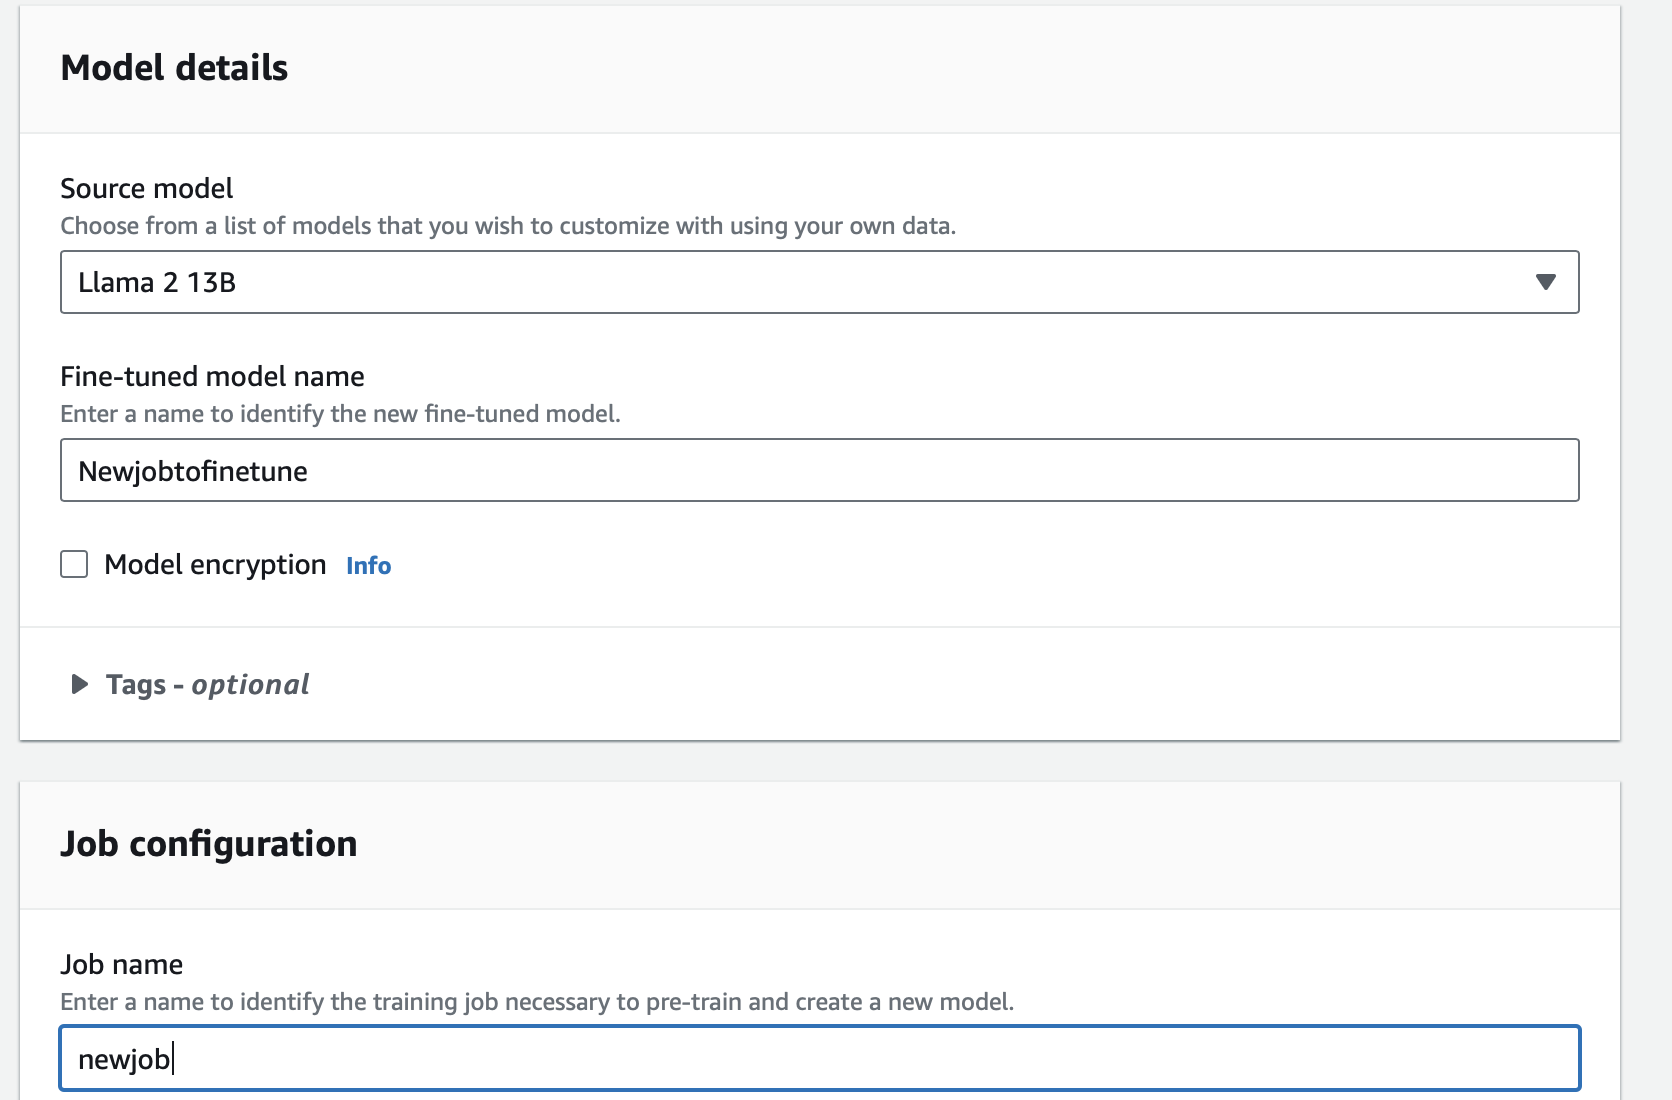


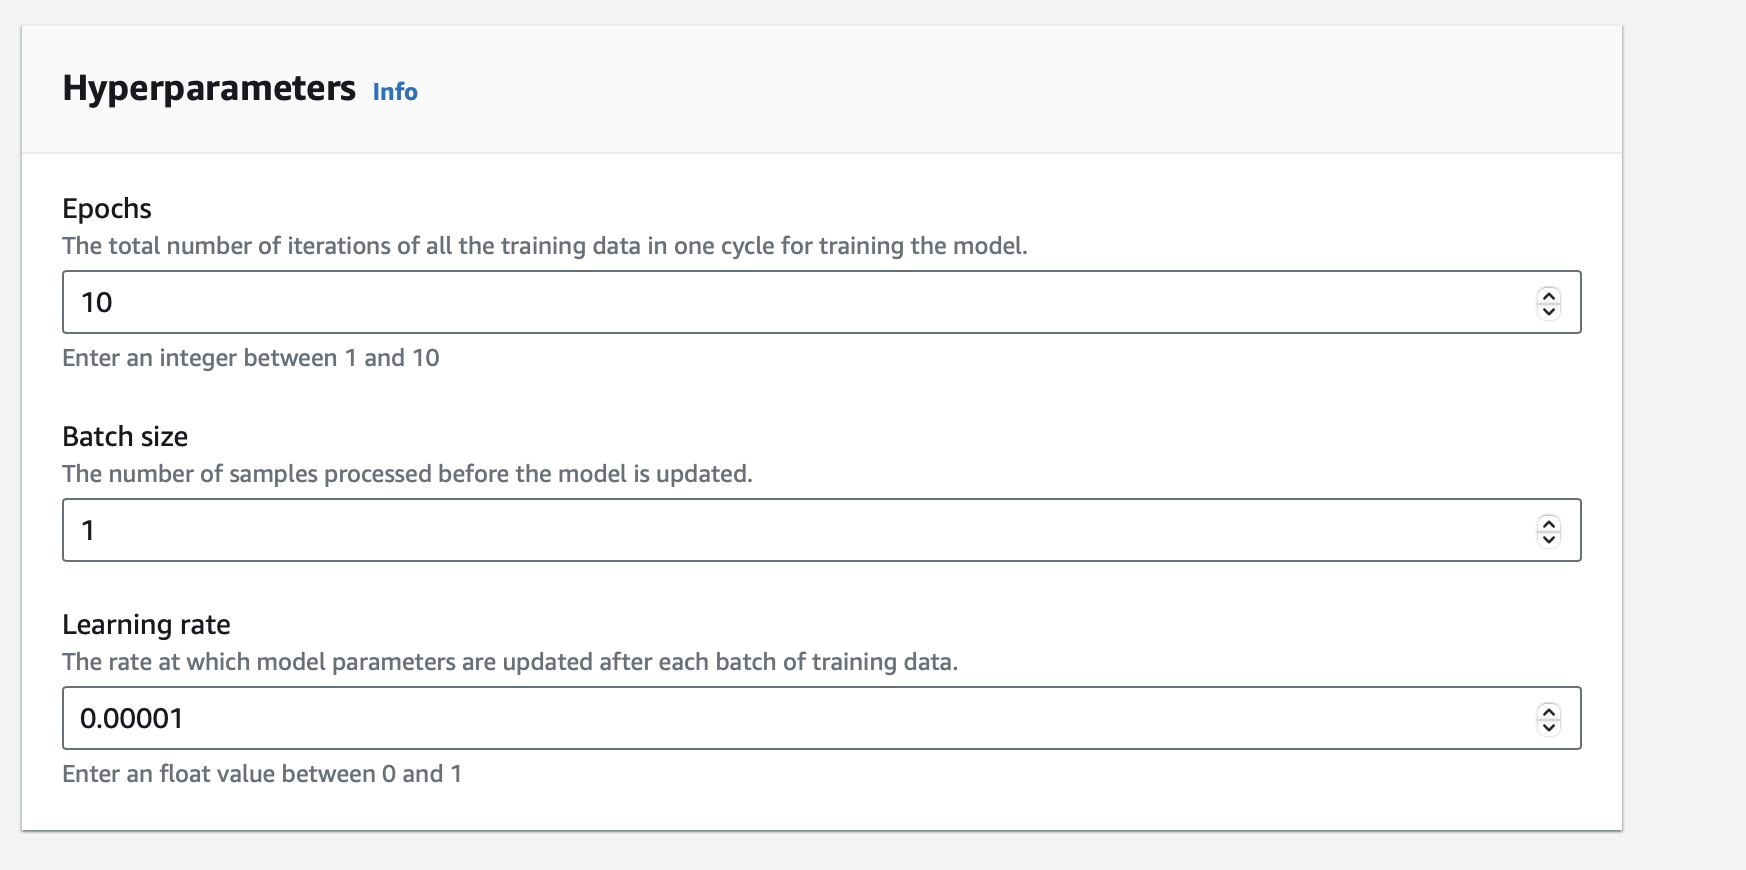

Now, start the training job:

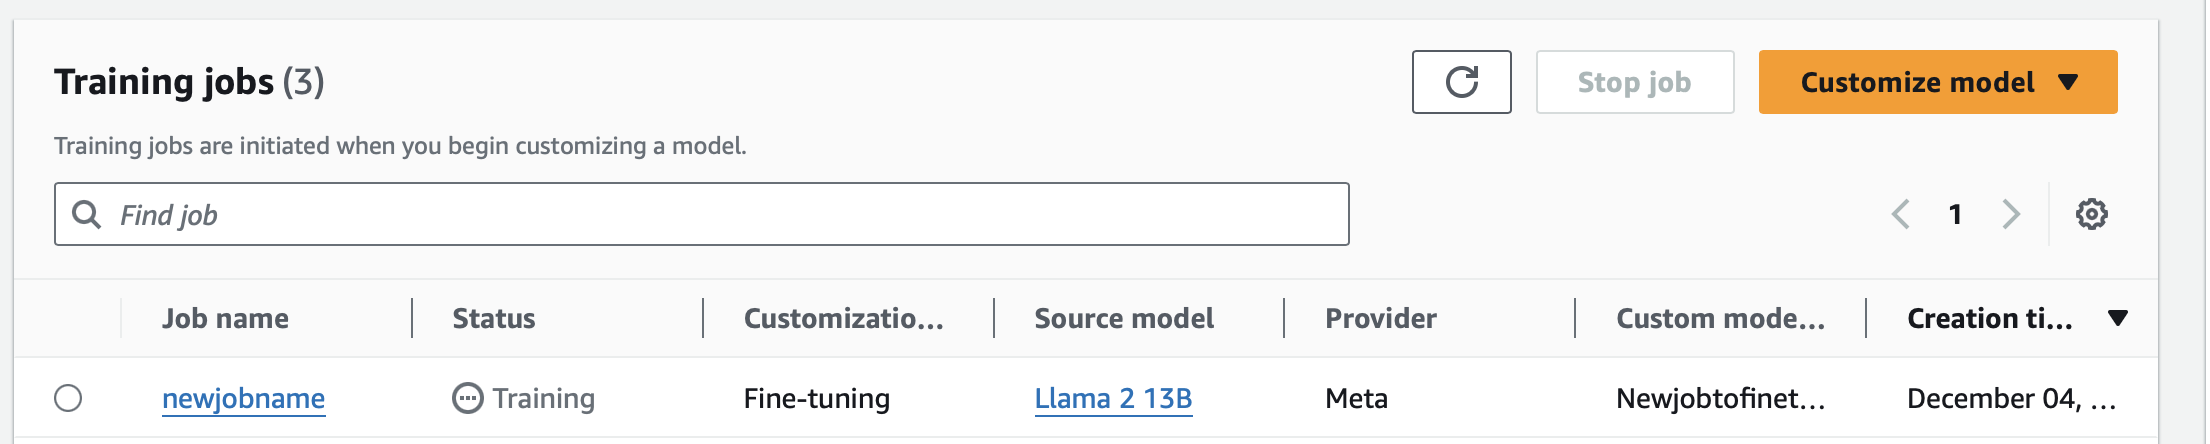

#### Now, we will do a walkthrough of how we can accomplish this via the SDK


To prepare for fine-tuning on Amazon Bedrock, I converted the dataset into JSON Lines format and uploaded it to Amazon S3. Each JSON line needs to have both a prompt and a completion field. You can specify up to 10,000 training data records, but you may already see model performance improvements with a few hundred examples.

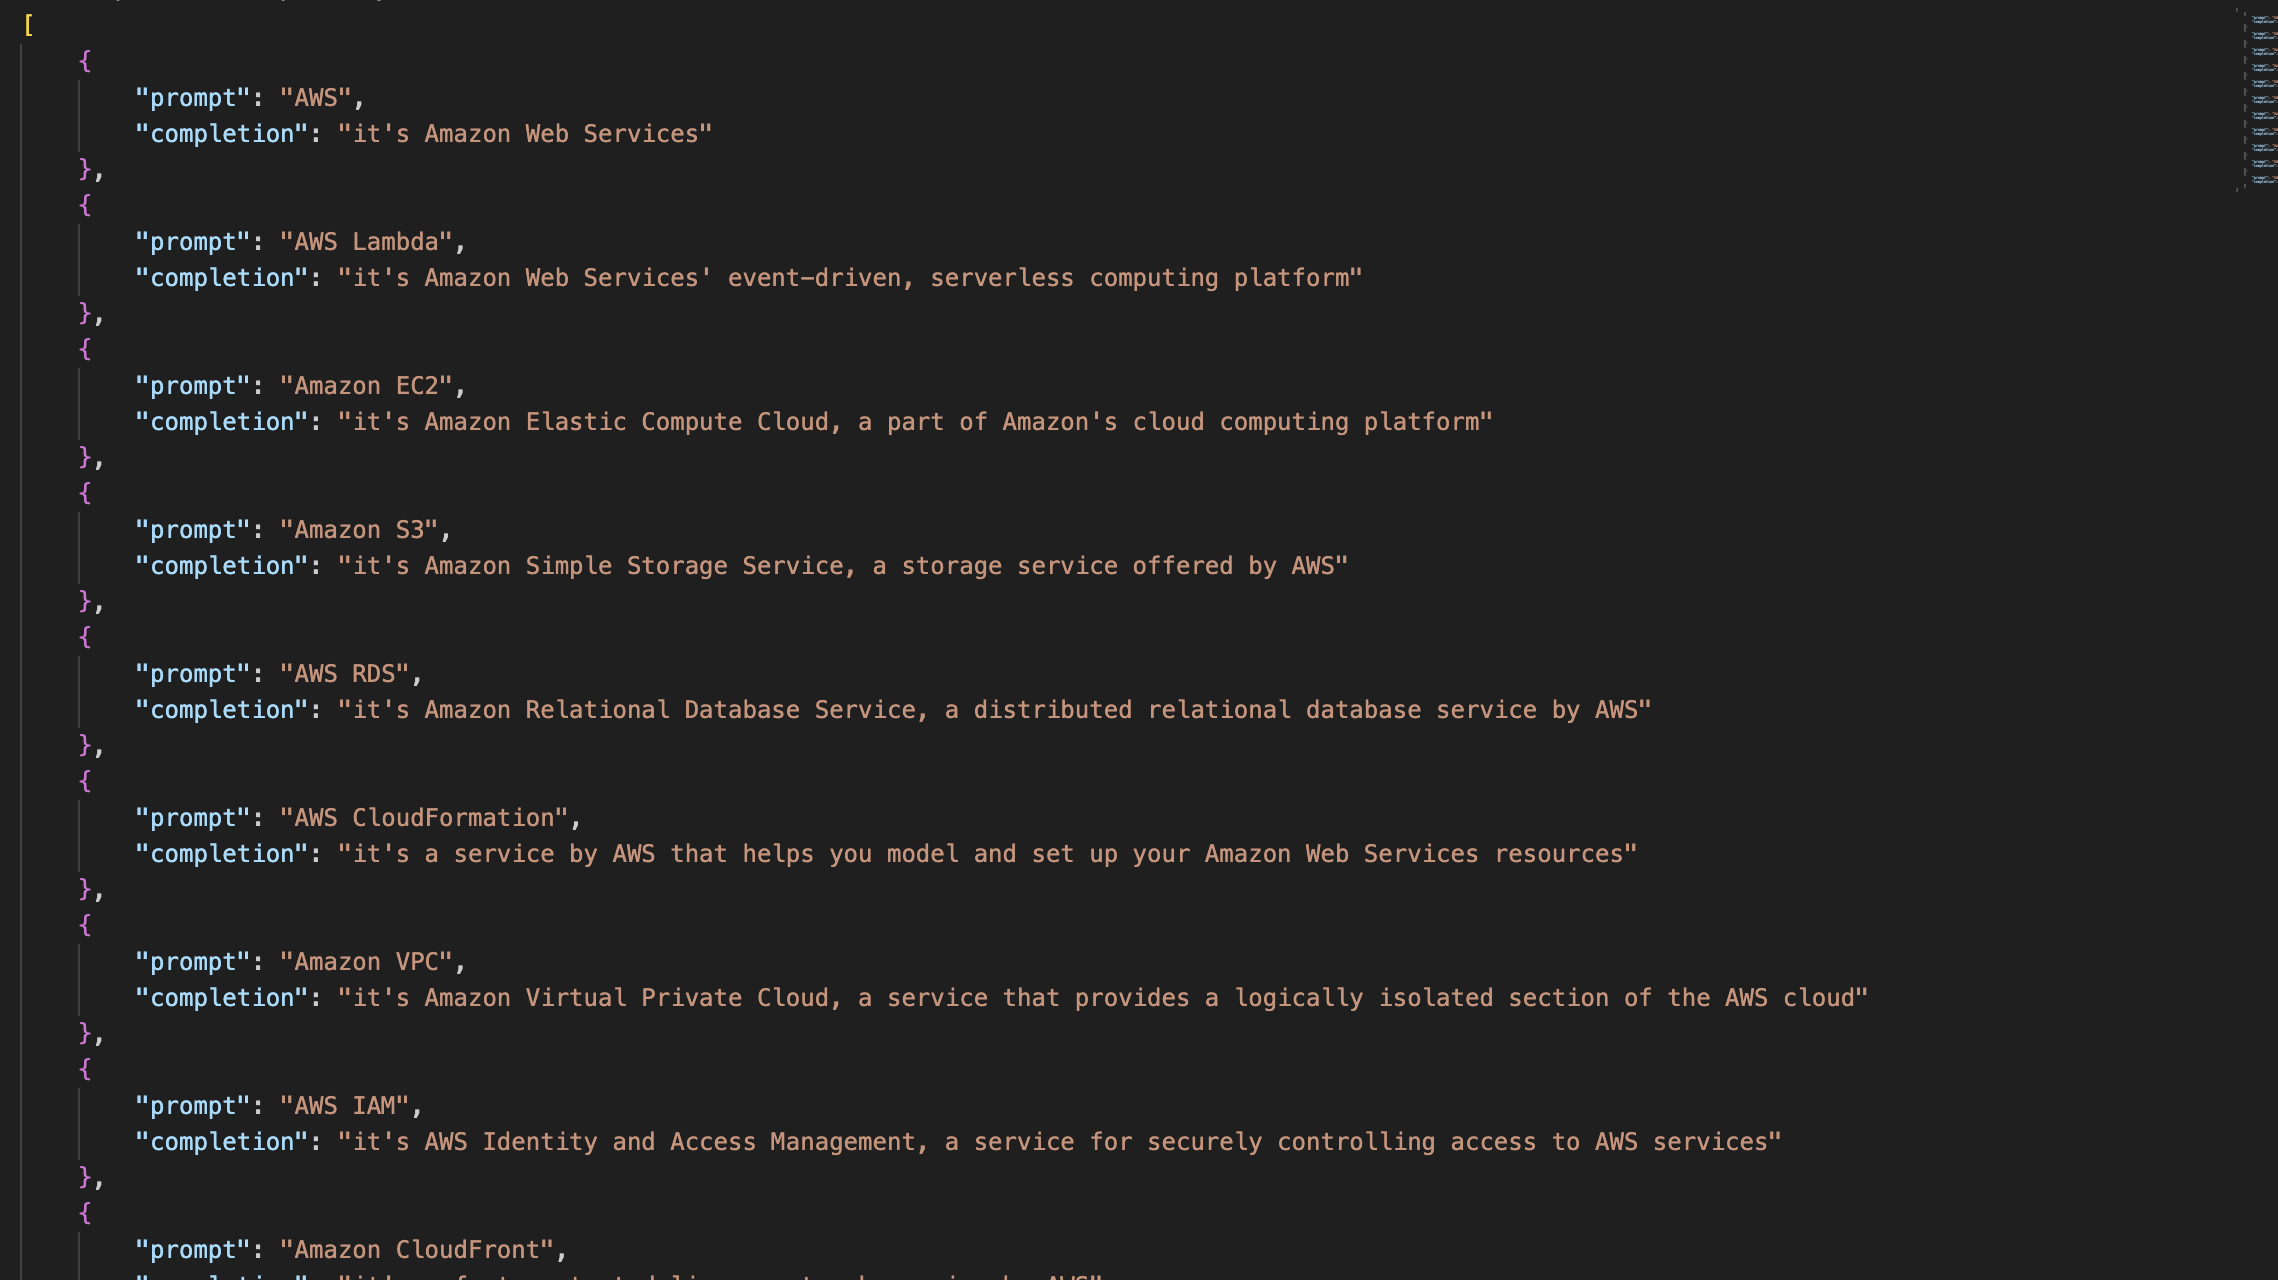

### List Foundational Models

In [2]:
## You can list available foundation models that support fine-tuning with the following command:

import boto3 
bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

for model in bedrock.list_foundation_models(
    byCustomizationType="FINE_TUNING")["modelSummaries"]:
    for key, value in model.items():
        print(key, ":", value)
    print("-----\n")

modelArn : arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-image-generator-v1:0
modelId : amazon.titan-image-generator-v1:0
modelName : Titan Image Generator G1
providerName : Amazon
inputModalities : ['TEXT', 'IMAGE']
outputModalities : ['IMAGE']
customizationsSupported : ['FINE_TUNING']
inferenceTypesSupported : ['ON_DEMAND', 'PROVISIONED']
modelLifecycle : {'status': 'ACTIVE'}
-----

modelArn : arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-text-lite-v1:0:4k
modelId : amazon.titan-text-lite-v1:0:4k
modelName : Titan Text G1 - Lite
providerName : Amazon
inputModalities : ['TEXT']
outputModalities : ['TEXT']
responseStreamingSupported : True
customizationsSupported : ['FINE_TUNING', 'CONTINUED_PRE_TRAINING']
inferenceTypesSupported : ['PROVISIONED']
modelLifecycle : {'status': 'ACTIVE'}
-----

modelArn : arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-text-express-v1:0:8k
modelId : amazon.titan-text-express-v1:0:8k
modelName : Titan Text G1 - Express
provid

### Create a model customization job

In [4]:
# Select the foundation model you want to customize
base_model_id = "" ## add your desired model id

bedrock.create_model_customization_job(
    customizationType="FINE_TUNING",
    jobName=job_name,
    customModelName=model_name,
    roleArn=role,
    baseModelIdentifier=base_model_id,
    hyperParameters = { ## set hyperparameters based on your use case
        "epochCount": "1",
        "batchSize": "8",
        "learningRate": "0.00001",
    },
    trainingDataConfig={"s3Uri": "s3://path/to/traindata.jsonl"},
    outputDataConfig={"s3Uri": "s3://path/to/output"},
)

# Check for the job status
status = bedrock.get_model_customization_job(jobIdentifier=job_name)["status"]
Python


#### Once the job is complete, you receive a unique model ID for your custom model. Your fine-tuned model is stored securely by Amazon Bedrock. To test and deploy your model, you need to purchase Provisioned Throughput.

### Use the Amazon Bedrock InvokeModel API

In [ ]:
body = {
    "prompt": prompt,
    "temperature": 0.5,
    "p": 0.9,
    "max_tokens": 512,
}

response = bedrock_runtime.invoke_model(
	# Use on-demand inference model ID for response before fine-tuning
    # modelId="modelId name",
	# Use ARN of your deployed custom model for response after fine-tuning
	modelId=provisioned_custom_model_arn,
    modelId=base_model_id, 
    body=json.dumps(body)
)